# Camera Calibration
---
Image distortion occurs when a camera looks at 3D objects in the real world and transforms them into a 2D image; this transformation isn’t perfect. Distortion actually changes what the shape and size of these 3D objects appear to be. So, the first step in analyzing camera images, is to undo this distortion so that you can get correct and useful information out of them.

Calibration will be done on known shapes, were we know the size and shape of given object. Then we are able to detect and correct any distortion in the image. Chessboard is one example of such object. Mulitple imgaes shall be taken, from different angels and zoom for proper calibration. The algorithm will find a difference between the shape and size of the object and their actual size and based on distorted points, it will calculate undistorted points in the image.

This will return distortion values array: (k1, k2, p1, p2, k3) and camera matrix.

It is recommended to use at least 20 images to get reilable calibration params.

Here is a great [tutorial](https://www.youtube.com/watch?v=lA-I22LtvD4) on camera calibration. Here is the [jypiter notebook](https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb) that follows the tutorial.

First, let's do it for one image, and later we will do it for all of them.
Load the neccessarry modules and open the image.

**NOTE: cv2 opens the image in BGR format and mpimg in RGB.**

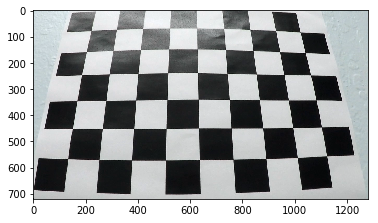

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Make a list of calibration images
fname = 'camera_cal/calibration3.jpg'
img = cv2.imread(fname)

# Number of corners of the chessboard used in example
nx = 9
ny = 6

plt.imshow(img)

### Finding corners
---
First we need to count the number of corners in any given row and enter that value in nx. Similarly, count the number of corners in a given column and store that in ny. Keep in mind that "corners" are only points where two black and two white squares intersect, in other words, only count inside corners, not outside corners.

We'll be using the OpenCV functions `findChessboardCorners()` and `drawChessboardCorners()` to automatically find and draw corners in an image of a chessboard pattern.

If corners were succesffuly found, we will draw them in order to properly visualize what are the functions doing.


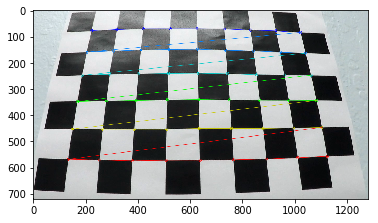

In [11]:

def FindCorners(img, nx = 9, ny = 6):
    """
    nx and ny represent number of internal corners in X and Y direction respectively
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    return ret, corners

ret, corners = FindCorners(img, nx, ny)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)

In [12]:

def ExtractObjectAndImgPoints(images, nx, ny):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Find the chessboard corners
    for img in images:
        ret, corners = FindCorners(img, nx, ny)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    return objpoints, imgpoints

Text(0.5,1,'Undistorted Image')

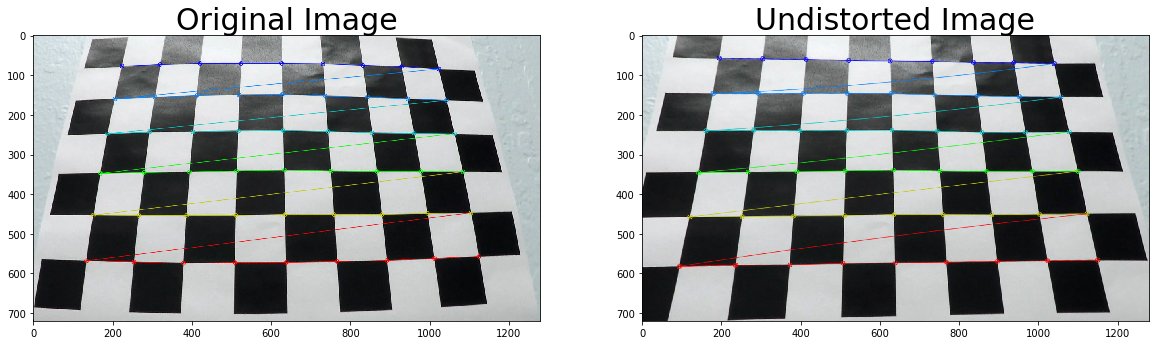

In [13]:
import pickle

def CalibrateCamera(img_size, objpoints, imgpoints):
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    return ret, mtx, dist, rvecs, tvecs

# Step through the list and search for chessboard corners
objpoints, imgpoints = ExtractObjectAndImgPoints(images, nx, ny)

ret, mtx, dist, rvecs, tvecs = CalibrateCamera((img.shape[0], img.shape[0]), objpoints, imgpoints)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)


Now, let's properly calibrate against all input images of chessboard and **save** parameters.

In [14]:
import glob

# Make a list of calibration images
image_names = glob.glob('camera_cal/calibration*.jpg')
images = []

# Step through the list and search for chessboard corners
for idx, fname in enumerate(image_names):
    img = cv2.imread(fname)
    images.append(img)

# Step through the list and search for chessboard corners
objpoints, imgpoints = ExtractObjectAndImgPoints(images, nx, ny)

# Get width and height of calibration images
img_shape = (images[0].shape[1], images[0].shape[0])
ret, mtx, dist, rvecs, tvecs = CalibrateCamera(img_shape, objpoints, imgpoints)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist

# Save params for python 2
pickle.dump( dist_pickle, open( "camera_cal/camera_cal_params_py2.p", "wb" ), protocol=2)
# Save params for python 3
pickle.dump( dist_pickle, open( "camera_cal/camera_cal_params_py3.p", "wb" ))  

A note on image shape

The shape of the image, which is passed into the calibrateCamera function, is just the height and width of the image. One way to retrieve these values is by retrieving them from the grayscale image shape array `gray.shape[::-1]`. This returns the image width and height in pixel values like (1280, 960).

Another way to retrieve the image shape, is to get them directly from the color image by retrieving the first two values in the color image shape array using `img.shape[1::-1]`. This code snippet asks for just the first two values in the shape array, and reverses them. Note that in our case we are working with a greyscale image, so we only have 2 dimensions (color images have three, height, width, and depth), so this is not necessary.

It's important to use an entire grayscale image shape or the first two values of a color image shape. This is because the entire shape of a color image will include a third value -- the number of color channels -- in addition to the height and width of the image. For example the shape array of a color image might be (960, 1280, 3), which are the pixel height and width of an image (960, 1280) and a third value (3) that represents the three color channels in the color image which you'll learn more about later, and if you try to pass these three values into the calibrateCamera function, you'll get an error.
